In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgen
from matplotlib import pyplot as plt
import os

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load the Dataset

In [7]:
SCATAC_DIR = '../data/scATAC/'

In [8]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks.h5ad')

CPU times: user 1.17 s, sys: 1min 21s, total: 1min 23s
Wall time: 1min 29s


In [9]:
scatac

AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

In [10]:
network = scgen.VAEArithKeras(scatac.shape[1], z_dimension=10, model_path='./models/scatac')

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20002)             0         
_________________________________________________________________
encoder (Model)              (None, 10)                16664020  
_________________________________________________________________
decoder (Model)              (None, 20002)             16676002  
Total params: 33,340,022
Trainable params: 33,333,622
Non-trainable params: 6,400
_________________________________________________________________


In [11]:
network.train(scatac, n_epochs=10, verbose=True, batch_size=128)


Epoch 1/10
70461/70461 [==============================] - 39s 547us/step - loss: 743.0331 - kl_loss: 113976.2891 - recon_loss: 737.3339
Epoch 2/10
70461/70461 [==============================] - 35s 497us/step - loss: 695.3302 - kl_loss: 33137.0469 - recon_loss: 693.6732
Epoch 3/10
70461/70461 [==============================] - 32s 458us/step - loss: 1065.1587 - kl_loss: 7544803.0000 - recon_loss: 687.9184
Epoch 4/10
70461/70461 [==============================] - 35s 493us/step - loss: 683.1058 - kl_loss: 3713.0625 - recon_loss: 682.9203
Epoch 5/10
70461/70461 [==============================] - 33s 464us/step - loss: 679.0080 - kl_loss: 381.3792 - recon_loss: 678.9894
Epoch 6/10
70461/70461 [==============================] - 35s 498us/step - loss: 676.1035 - kl_loss: 402.4214 - recon_loss: 676.0837
Epoch 7/10
70461/70461 [==============================] - 32s 455us/step - loss: 674.1679 - kl_loss: 286.9808 - recon_loss: 674.1537
Epoch 8/10
70461/70461 [==============================] -

In [10]:
CT = '12_CD14.Mono.2'

In [ ]:
indices = np.random.choice(range(scatac.shape[0]), size=2000, replace=False)
adata = scatac[indices]
pred, delta = network.predict(adata, conditions={'ctrl': 'control', 'stim': 'stimulated'},
                              cell_type_key='cell_type', condition_key='condition',
                              celltype_to_predict=CT)

In [12]:
adata = scatac

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

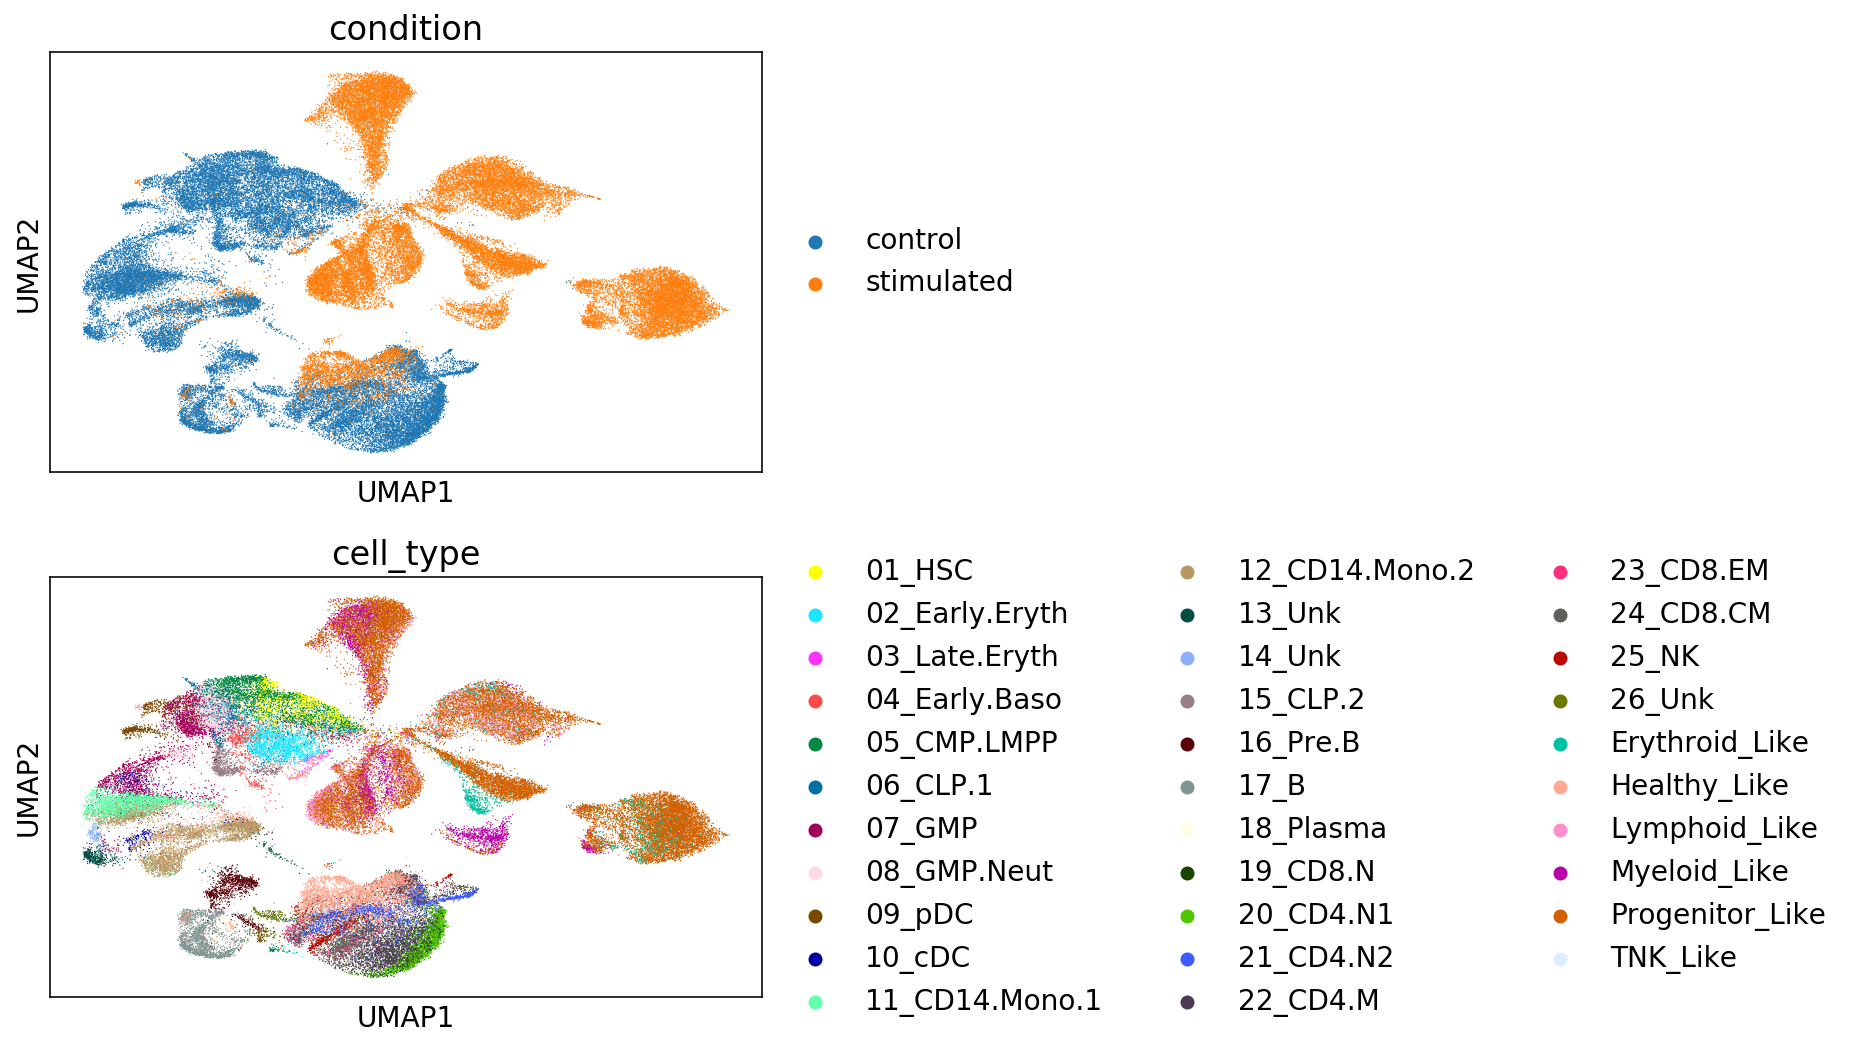

In [13]:
sc.pp.neighbors(adata, random_state=42)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color=['condition', 'cell_type'], ncols=1)

In [14]:
adata_latent = network.to_latent(adata.X)
adata_latent = sc.AnnData(adata_latent)
adata_latent.obs = adata.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

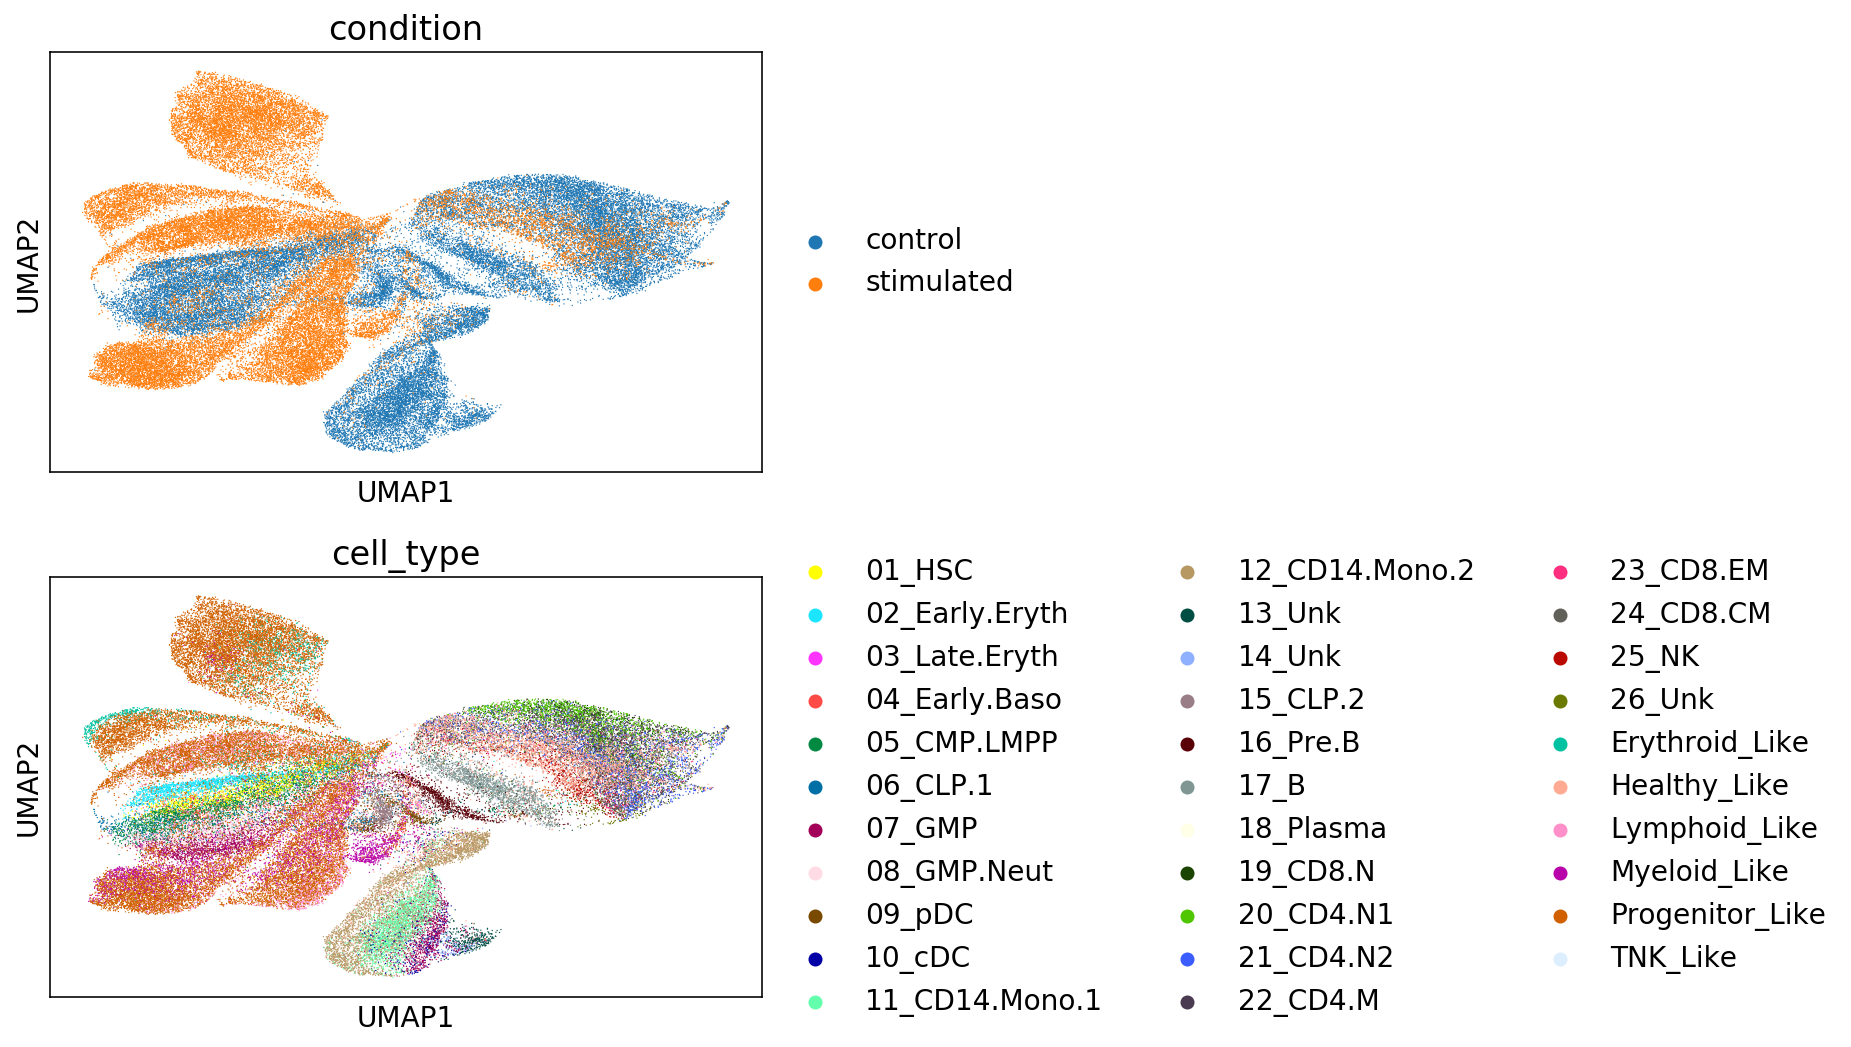

In [15]:
sc.pp.neighbors(adata_latent, random_state=42)
sc.tl.umap(adata_latent, random_state=42)
sc.pl.umap(adata_latent, color=['condition', 'cell_type'], ncols=1)

In [18]:
delta = np.mean(adata_latent[adata_latent.obs['condition'] == 'stimulated'].X, axis=0, keepdims=True) - \
        np.mean(adata_latent[adata_latent.obs['condition'] == 'control'].X, axis=0, keepdims=True)
delta

ArrayView([[-0.6810692 ,  3.9651718 ,  0.9522366 ,  1.6371553 ,
             5.1937017 , -3.9511423 , -3.6895993 ,  0.35551175,
             4.1412683 , -6.1507707 ]], dtype=float32)

In [19]:
adata_latent[adata_latent.obs['condition'] == 'control'].X += delta

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


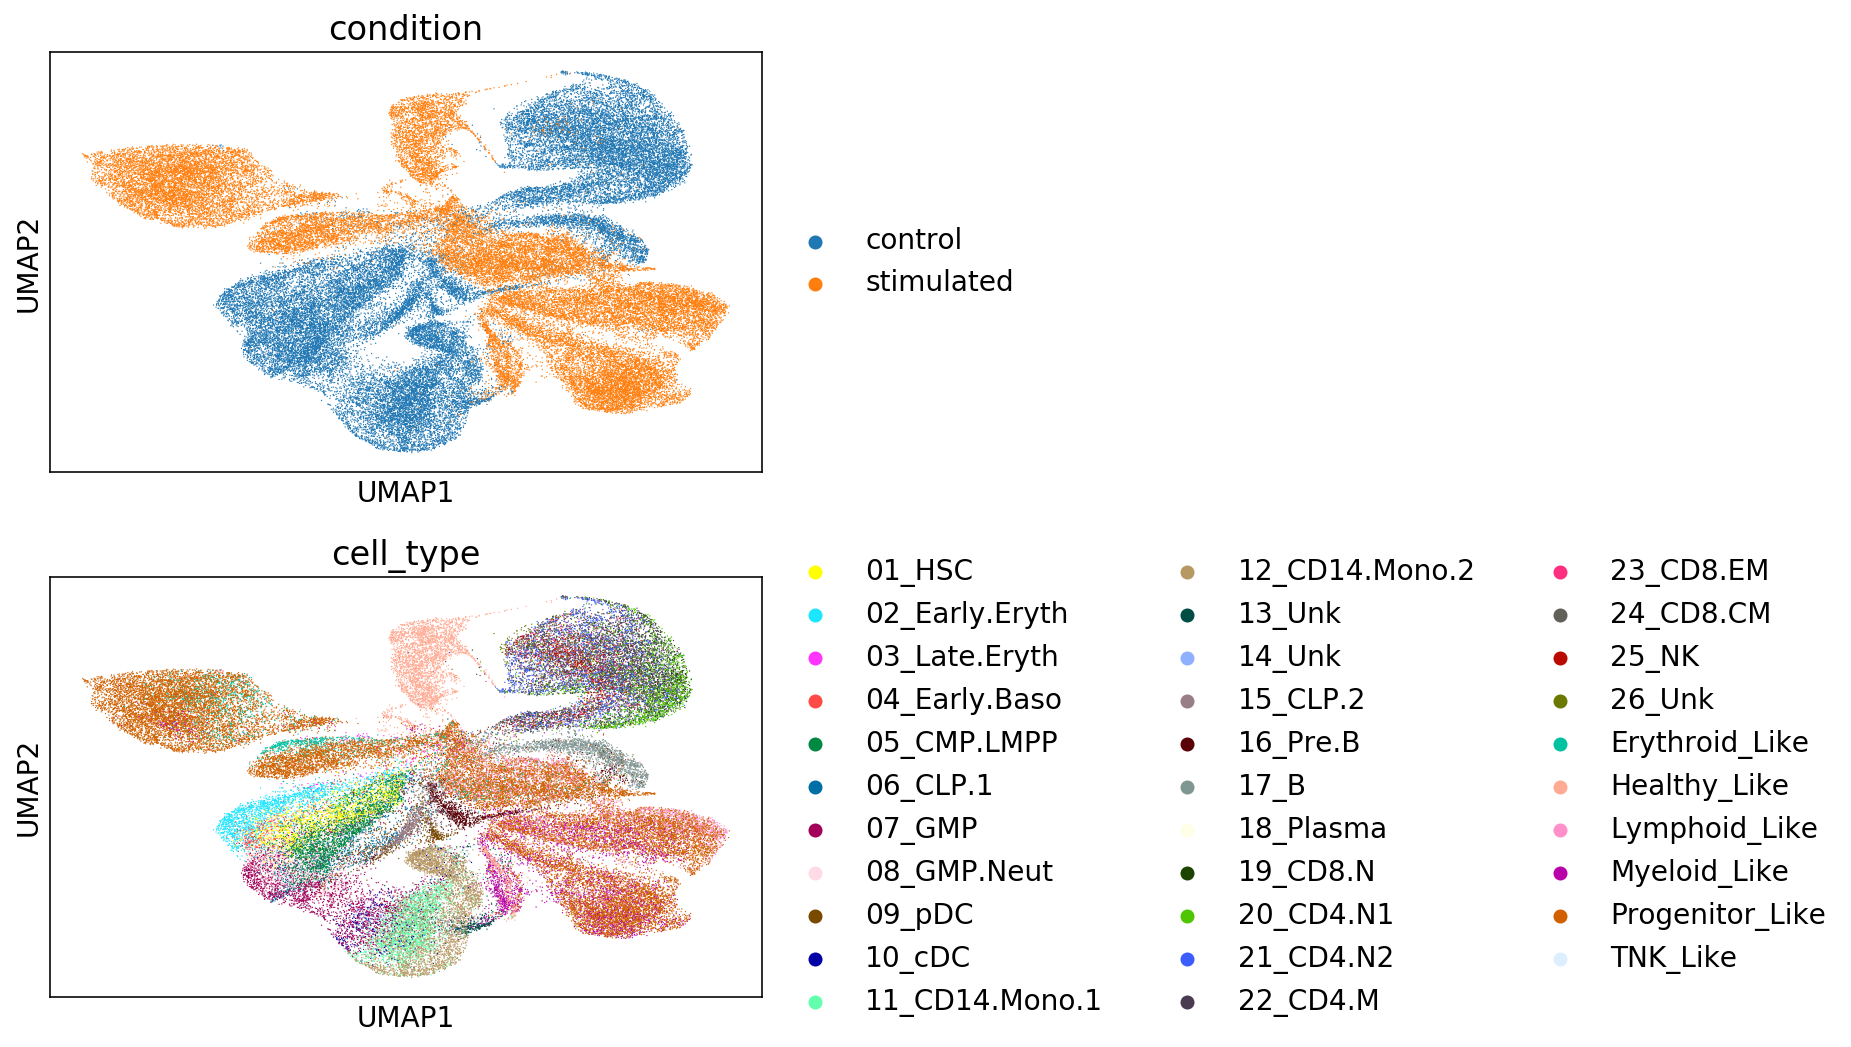

In [20]:
sc.pp.neighbors(adata_latent, random_state=42)
sc.tl.umap(adata_latent, random_state=42)
sc.pl.umap(adata_latent, color=['condition', 'cell_type'], ncols=1)